In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
%run functions.ipynb
configurate_display()

# Data preparation

In [3]:
df = read_file_csv(get_model_dataset_path())
df.shape

(36025, 437)

In [4]:
X, y = df.loc[:, ~df.columns.isin([get_model_target(), get_model_index()] + get_categorical_features())], df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
data_train = xgb.DMatrix(data=X_train,label=y_train)
data_test = xgb.DMatrix(data=X_test)

# Grid search CV

In [6]:
params_grid = {
        'min_child_weight': [5, 10],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.8],
        'max_depth': [5, 10],
        'learning_rate': [0.2, 0.7],
        }

In [7]:
clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(clf_xgb, param_grid=params_grid, cv = 3, n_jobs=-1, scoring='roc_auc', return_train_score = True, verbose=10)
gs_execution = grid_search.fit(X_train, y_train)
print('Best x-val roc train: ' + str(grid_search.best_score_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best x-val roc train: 0.6760552298550162


In [8]:
print('Best parameters:')
grid_search.best_params_

Best parameters:


{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 10,
 'subsample': 0.8}

In [9]:
df_mean_train_score = pd.DataFrame(grid_search.cv_results_['mean_train_score'], columns=['mean_train_score'])
df_mean_test_score = pd.DataFrame(grid_search.cv_results_['mean_test_score'], columns=['mean_test_score'])
df_cv_execution = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), df_mean_train_score, df_mean_test_score],axis=1)

print('The following table shows a considerable decrease of the x-val test roc over the x-val train roc, which means that \
the model is overfitted, so it is necessary to improve the parameters. \
Anyway this test roc improves our min roc reachable, the decision tree roc which was 66%.')

df_cv_execution[df_cv_execution.index == 3]

The following table shows a considerable decrease of the x-val test roc over the x-val train roc, which means that the model is overfitted, so it is necessary to improve the parameters. Anyway this test roc improves our min roc reachable, the decision tree roc which was 66%.


,colsample_bytree,learning_rate,max_depth,min_child_weight,subsample,mean_train_score,mean_test_score
3,0.8,0.2,5,10,0.8,0.797387,0.676055


# Train

In [10]:
model = xgb.train(params=grid_search.best_estimator_.get_xgb_params(), dtrain=data_train)

# Feature importance

This chart shows the xgboost feature importance and its scores:


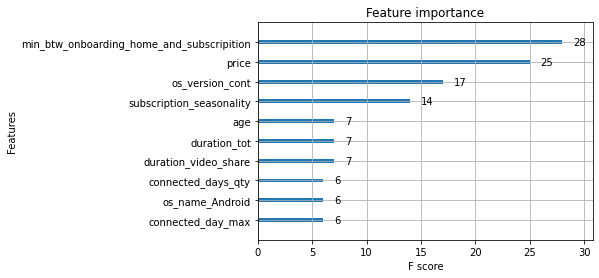

In [11]:
xgb.plot_importance(model, max_num_features = 10, importance_type='weight')
print('This chart shows the xgboost feature importance and its scores:')
plt.show()

Insight age: In the following chart we can observe a decrease in adoption related to increasing age. It could be a good opcion to focus on the age range over 8 years old.


<AxesSubplot:xlabel='age'>

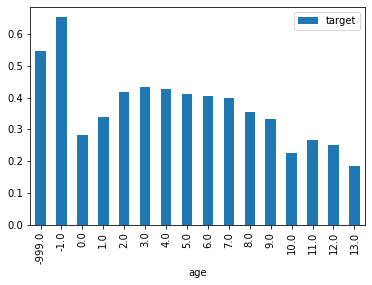

In [12]:
#Insight ages
print('Insight age: In the following chart we can observe a decrease in adoption related to increasing age. \
It could be a good opcion to focus on the age range over 8 years old.')

(df.groupby('age')['target'].mean().to_frame()).plot.bar()

# Prediccion

In [13]:
y_pred = model.predict(data_test)
print('Final model test roc: ' + str(roc_auc_score(y_test, y_pred)))
print('The test roc is close to x-val test roc which makes sense and it is over the decision tree roc.')

Final model test roc: 0.6817995678531128
The test roc is close to x-val test roc which makes sense and it is over the decision tree roc.
